In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import requests
import pandas as pd
from time import sleep

def get_weather_data(city, lat, lon, start='20150101', end='20241231'):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOT,RH2M,WS2M,ALLSKY_SFC_SW_DWN",
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start,
        "end": end,
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    
    try:
        data = response.json()
        if 'properties' not in data:
            print(f"⚠️ API error for {city}: {data}")
            return pd.DataFrame()  # Return empty DataFrame on error

        parameters = data['properties']['parameter']
        df = pd.DataFrame(parameters)
        df.index.name = 'Date'
        df.index = pd.to_datetime(df.index)
        df['City'] = city
        return df

    except Exception as e:
        print(f"❌ Failed to parse data for {city}: {e}")
        return pd.DataFrame()


# Define cities and coordinates
cities = {
    "Abuja": (9.0579, 7.4951),
    "Ilorin": (8.4966, 4.5421),
    "Maiduguri": (11.8311, 13.1500),
    "Yola": (9.2035, 12.4954),
    "Kano": (12.0022, 8.5919),
    "Sokoto": (13.0059, 5.2476),
    "Enugu": (6.5244, 7.5189),
    "Owerri": (5.4836, 7.0330),
    "Port Harcourt": (4.8156, 7.0498),
    "Calabar": (4.9589, 8.3269),
    "Lagos": (6.5244, 3.3792),
    "Ibadan": (7.3775, 3.9470)
}

# Fetch and save data
all_data = []
for city, (lat, lon) in cities.items():
    print(f"Fetching data for {city}...")
    df = get_weather_data(city, lat, lon)
    df.to_csv(f"{city}_weather_2015_2024.csv")
    all_data.append(df)
    sleep(1)  # Be kind to the API

# Combine all into one DataFrame
combined_df = pd.concat(all_data)
combined_df.to_csv("Nigeria_Weather_2015_2024_All_Cities.csv")

Fetching data for Abuja...
Fetching data for Ilorin...
Fetching data for Maiduguri...
Fetching data for Yola...
Fetching data for Kano...
Fetching data for Sokoto...
Fetching data for Enugu...
Fetching data for Owerri...
Fetching data for Port Harcourt...
Fetching data for Calabar...
Fetching data for Lagos...
Fetching data for Ibadan...


In [3]:
combined_df.head()

,ALLSKY_SFC_SW_DWN,T2M_MAX,T2M_MIN,RH2M,WS2M,T2M,PRECTOTCORR,City
Date,,,,,,,,
2015-01-01,5.57,34.50,17.07,32.32,2.12,25.07,0.0,Abuja
2015-01-02,5.87,34.91,16.15,29.53,2.46,24.43,0.0,Abuja
2015-01-03,5.63,35.13,16.26,25.65,3.64,24.22,0.0,Abuja
2015-01-04,5.64,34.51,15.36,24.25,3.78,23.51,0.0,Abuja
2015-01-05,4.80,33.12,15.20,27.83,2.46,23.01,0.0,Abuja


In [4]:
combined_df.shape

(43836, 8)

In [5]:
column_mapping = {
    "ALLSKY_SFC_SW_DWN": "Solar_Radiation (W/m²)",
    "T2M_MAX": "Max_Temperature (°C)",
    "T2M_MIN": "Min_Temperature (°C)",
    "T2M": "Avg_Temperature (°C)",
    "WS2M": "Wind_Speed_2m (m/s)",
    "RH2M": "Relative_Humidity_2m (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "City": "City"
}
combined_df.rename(columns=column_mapping, inplace=True)

In [6]:
zone_mapping = {
    "Abuja": "North Central",
    "Ilorin": "North Central",
    "Maiduguri": "North East",
    "Yola": "North East",
    "Kano": "North West",
    "Sokoto": "North West",
    "Enugu": "South East",
    "Owerri": "South East",
    "Port Harcourt": "South South",
    "Calabar": "South South",
    "Lagos": "South West",
    "Ibadan": "South West"
}
combined_df["Geopolitical Zone"] = combined_df["City"].map(zone_mapping)
combined_df.head()

,Solar_Radiation (W/m²),Max_Temperature (°C),Min_Temperature (°C),Relative_Humidity_2m (%),Wind_Speed_2m (m/s),Avg_Temperature (°C),Precipitation (mm/day),City,Geopolitical Zone
Date,,,,,,,,,
2015-01-01,5.57,34.50,17.07,32.32,2.12,25.07,0.0,Abuja,North Central
2015-01-02,5.87,34.91,16.15,29.53,2.46,24.43,0.0,Abuja,North Central
2015-01-03,5.63,35.13,16.26,25.65,3.64,24.22,0.0,Abuja,North Central
2015-01-04,5.64,34.51,15.36,24.25,3.78,23.51,0.0,Abuja,North Central
2015-01-05,4.80,33.12,15.20,27.83,2.46,23.01,0.0,Abuja,North Central


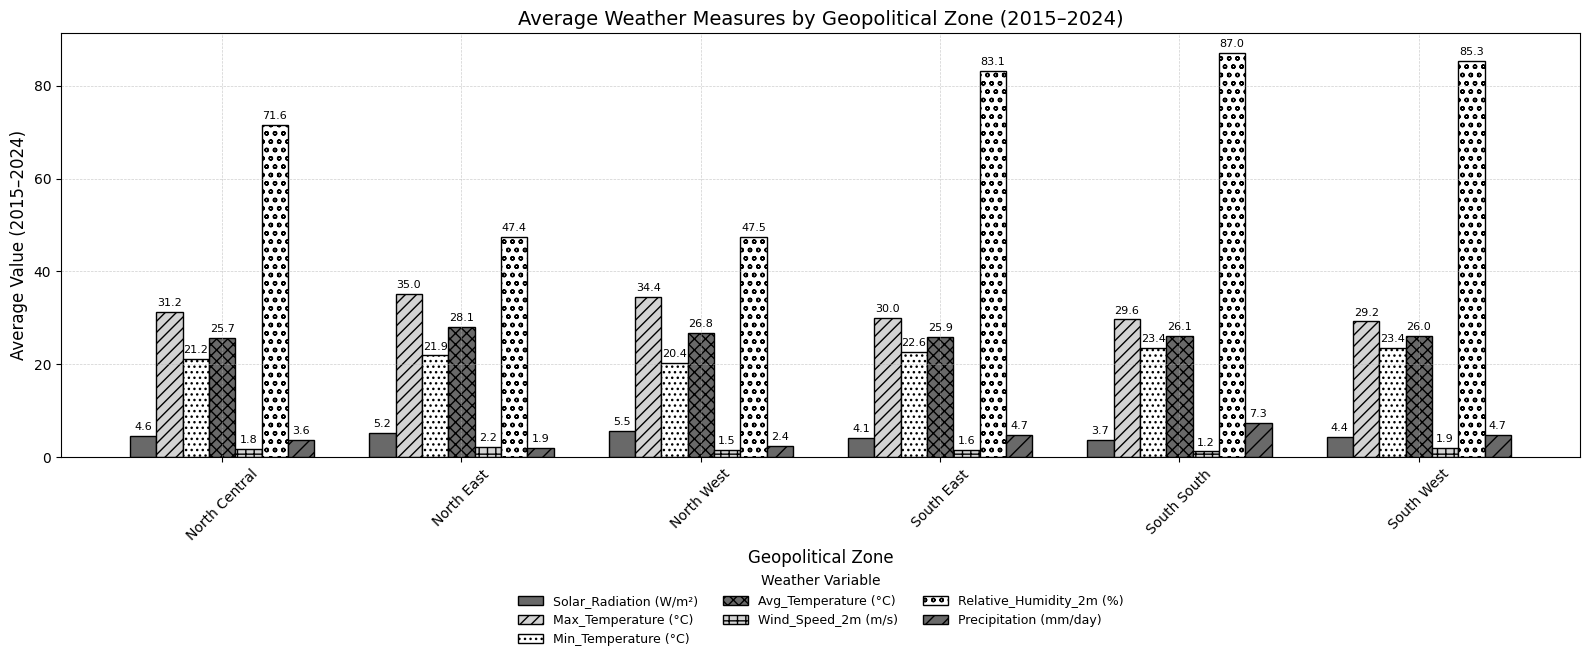

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Weather variables to plot
weather_vars = [
    "Solar_Radiation (W/m²)",
    "Max_Temperature (°C)",
    "Min_Temperature (°C)",
    "Avg_Temperature (°C)",
    "Wind_Speed_2m (m/s)",
    "Relative_Humidity_2m (%)",
    "Precipitation (mm/day)"
]

# Group by Geopolitical Zone
zone_means = combined_df.groupby("Geopolitical Zone")[weather_vars].mean()
zones = zone_means.index.tolist()
x = np.arange(len(zones))
width = 0.11

# Define alternating styles (black, gray, white with hatching)
styles = [
    {'color': 'dimgray', 'hatch': ''},
    {'color': 'lightgray', 'hatch': '///'},
    {'color': 'white', 'hatch': '...'},
    {'color': 'dimgray', 'hatch': 'xxx'},
    {'color': 'lightgray', 'hatch': '++'},
    {'color': 'white', 'hatch': 'oo'},
    {'color': 'dimgray', 'hatch': '//'}
]

fig, ax = plt.subplots(figsize=(16, 7))

# Plot each variable with alternating styles
for i, var in enumerate(weather_vars):
    style = styles[i % len(styles)]
    bars = ax.bar(x + i * width, zone_means[var], width,
                  label=var,
                  color=style['color'],
                  hatch=style['hatch'],
                  edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_xlabel("Geopolitical Zone", fontsize=12)
ax.set_ylabel("Average Value (2015–2024)", fontsize=12)
ax.set_title("Average Weather Measures by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xticks(x + width * (len(weather_vars) - 1) / 2)
ax.set_xticklabels(zones, rotation=45)
ax.legend(
    title="Weather Variable",
    fontsize=9,
    title_fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),  # moved further down
    ncol=3,
    frameon=False
)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

In [8]:
zone_means.round(2)

,Solar_Radiation (W/m²),Max_Temperature (°C),Min_Temperature (°C),Avg_Temperature (°C),Wind_Speed_2m (m/s),Relative_Humidity_2m (%),Precipitation (mm/day)
Geopolitical Zone,,,,,,,
North Central,4.60,31.24,21.17,25.69,1.76,71.63,3.62
North East,5.25,35.04,21.88,28.07,2.21,47.35,1.94
North West,5.54,34.39,20.36,26.77,1.52,47.46,2.42
South East,4.11,29.99,22.56,25.90,1.55,83.09,4.73
South South,3.66,29.63,23.44,26.14,1.19,86.99,7.27
South West,4.35,29.21,23.40,25.99,1.86,85.25,4.73


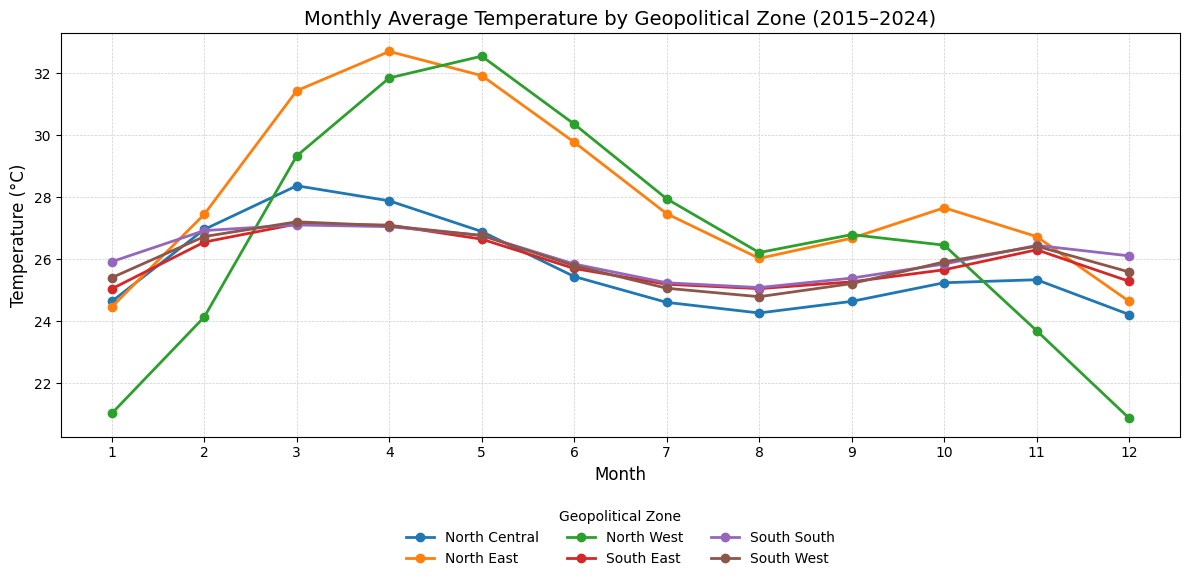

In [9]:
import matplotlib.pyplot as plt

# Ensure 'Month' column exists
combined_df['Month'] = combined_df.index.month

# Group by Month and Geopolitical Zone
monthly_zone_avg = combined_df.groupby(['Month', 'Geopolitical Zone'])[
    "Avg_Temperature (°C)"
].mean().reset_index()

# Pivot temperature data
temp_data = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Avg_Temperature (°C)')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors

for i, zone in enumerate(temp_data.columns):
    ax.plot(temp_data.index, temp_data[zone], label=zone, color=colors[i], marker='o', linewidth=2)

ax.set_title("Monthly Average Temperature by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.set_xticks(range(1, 13))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title="Geopolitical Zone", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [10]:
monthly_temp_table = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Avg_Temperature (°C)')
monthly_temp_table.round(2)

Geopolitical Zone,North Central,North East,North West,South East,South South,South West
Month,,,,,,
1,24.64,24.46,21.02,25.04,25.92,25.40
2,26.96,27.45,24.13,26.55,26.92,26.73
3,28.37,31.44,29.33,27.14,27.10,27.21
4,27.88,32.70,31.85,27.10,27.05,27.08
5,26.89,31.92,32.55,26.65,26.76,26.77
6,25.44,29.77,30.36,25.70,25.84,25.79
7,24.60,27.46,27.95,25.19,25.24,25.06
8,24.26,26.03,26.21,25.05,25.08,24.79
9,24.64,26.68,26.79,25.27,25.39,25.21


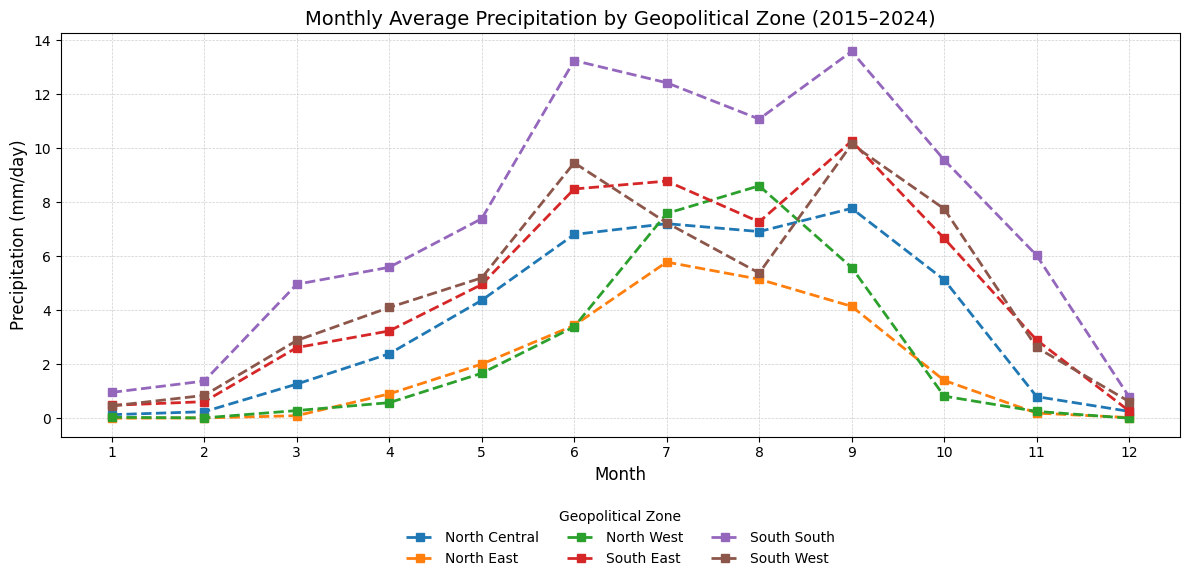

In [11]:
# Ensure 'Month' column exists
combined_df['Month'] = combined_df.index.month

# Group by Month and Geopolitical Zone for multiple variables
monthly_zone_avg = combined_df.groupby(['Month', 'Geopolitical Zone'])[
    [
        "Avg_Temperature (°C)",
        "Precipitation (mm/day)"
    ]
].mean().reset_index()


# Pivot precipitation data
rain_data = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Precipitation (mm/day)')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, zone in enumerate(rain_data.columns):
    ax.plot(rain_data.index, rain_data[zone], label=zone, color=colors[i], linestyle='--', marker='s', linewidth=2)

ax.set_title("Monthly Average Precipitation by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/day)", fontsize=12)
ax.set_xticks(range(1, 13))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title="Geopolitical Zone", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [12]:
monthly_rain_table = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Precipitation (mm/day)')
monthly_rain_table.round(2)

Geopolitical Zone,North Central,North East,North West,South East,South South,South West
Month,,,,,,
1,0.13,0.00,0.03,0.48,0.96,0.46
2,0.24,0.01,0.01,0.61,1.38,0.84
3,1.26,0.09,0.28,2.62,4.96,2.88
4,2.39,0.90,0.58,3.23,5.59,4.10
5,4.37,2.00,1.67,4.95,7.39,5.20
6,6.81,3.44,3.39,8.49,13.25,9.46
7,7.21,5.78,7.59,8.79,12.43,7.24
8,6.92,5.15,8.61,7.27,11.08,5.38
9,7.77,4.14,5.58,10.27,13.59,10.15


In [13]:
combined_df.drop(columns='Month').describe().round(2)

,Solar_Radiation (W/m²),Max_Temperature (°C),Min_Temperature (°C),Relative_Humidity_2m (%),Wind_Speed_2m (m/s),Avg_Temperature (°C),Precipitation (mm/day)
count,43836.00,43836.00,43836.00,43836.00,43836.00,43836.00,43836.00
mean,4.59,31.58,22.13,70.30,1.68,26.43,4.12
std,22.01,3.79,3.28,24.02,0.79,2.65,9.10
min,-999.00,18.83,5.88,3.89,0.10,13.18,0.00
25%,4.37,28.95,21.31,57.44,1.11,25.05,0.00
50%,5.24,30.55,22.86,82.08,1.54,26.15,0.93
75%,5.94,33.29,24.03,88.17,2.11,27.39,4.58
max,8.20,45.56,32.30,96.53,5.78,38.49,287.97


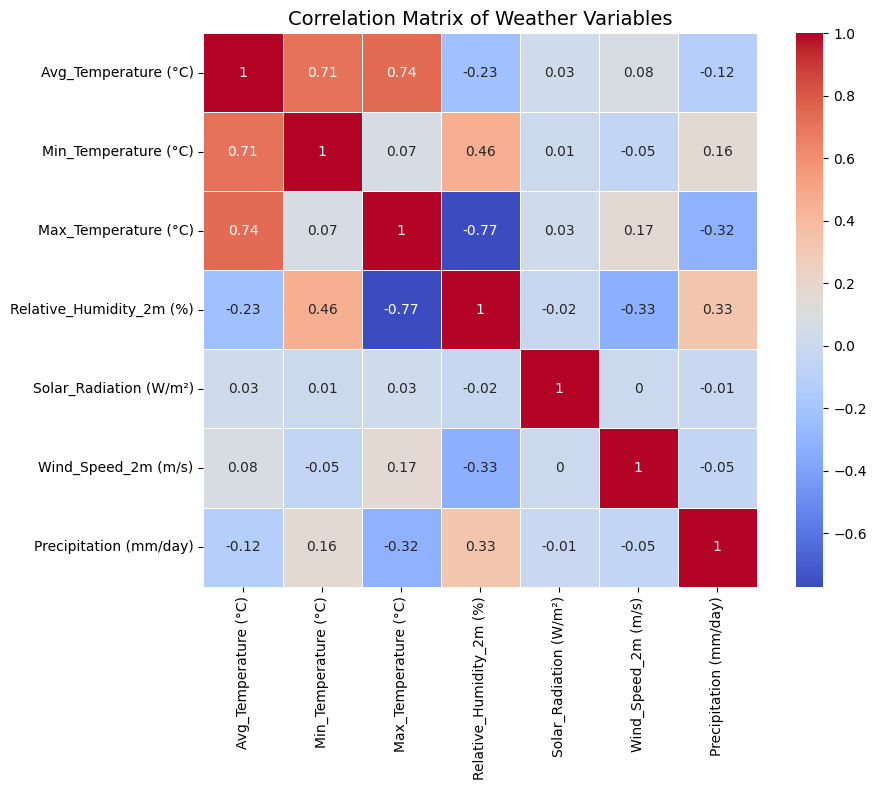

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric weather columns
weather_vars = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Compute correlation matrix
corr_matrix = combined_df[weather_vars].corr().round(2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title("Correlation Matrix of Weather Variables", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Step 1: Add 'Month' and 'Season'
combined_df['Month'] = combined_df.index.month
combined_df['Season'] = combined_df['Month'].apply(lambda m: 'Dry' if m in [11, 12, 1, 2, 3] else 'Rainy')

# Step 2: Compute seasonal averages and round to 2 decimal places
seasonal_avg = combined_df.groupby(['Geopolitical Zone', 'Season'])[
    [
        "Avg_Temperature (°C)",
        "Min_Temperature (°C)",
        "Max_Temperature (°C)",
        "Relative_Humidity_2m (%)",
        "Solar_Radiation (W/m²)",
        "Wind_Speed_2m (m/s)",
        "Precipitation (mm/day)"
    ]
].mean().round(2)

# Step 3: Define highlighting function
def highlight_extremes(df):
    def style_column(s):
        is_max = s == s.max()
        is_min = s == s.min()
        return ['color: red' if v else 'color: blue' if w else '' for v, w in zip(is_max, is_min)]
    
    return df.style.apply(style_column, subset=df.columns, axis=0).format("{:.2f}")

# Step 4: Display styled and rounded table
highlight_extremes(seasonal_avg)

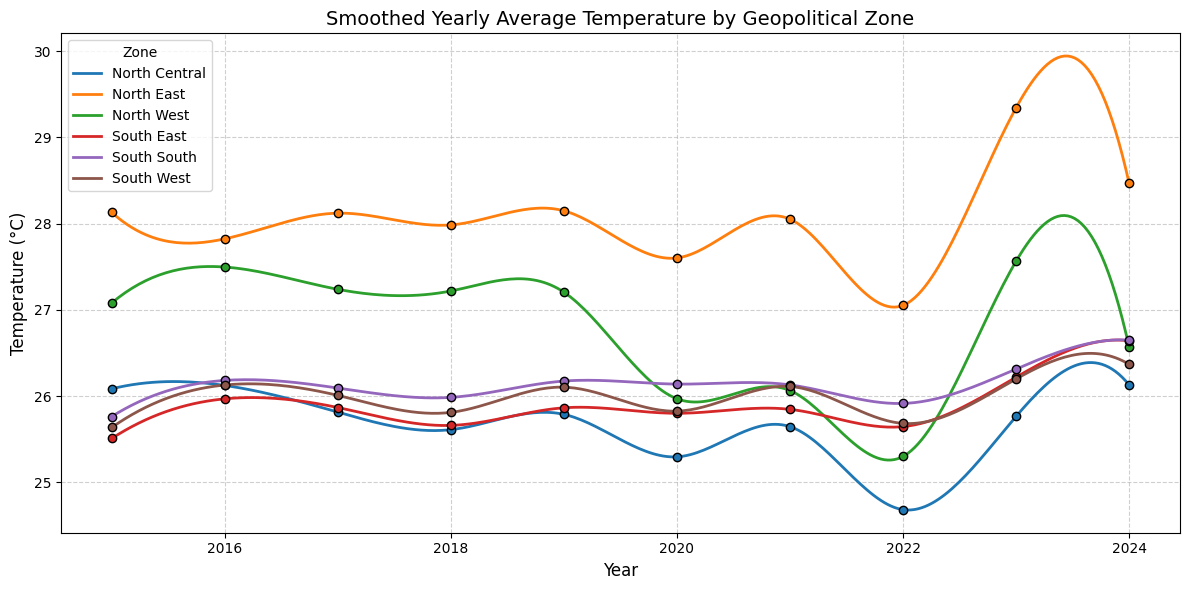

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Ensure 'Year' column exists
combined_df['Year'] = combined_df.index.year

# Group by Year and Geopolitical Zone
yearly_avg = combined_df.groupby(['Year', 'Geopolitical Zone'])[
    "Avg_Temperature (°C)"
].mean().reset_index()



fig, ax = plt.subplots(figsize=(12, 6))

for zone in yearly_avg['Geopolitical Zone'].unique():
    zone_data = yearly_avg[yearly_avg['Geopolitical Zone'] == zone]
    x = zone_data['Year']
    y = zone_data["Avg_Temperature (°C)"]

    # Smooth curve
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)

    # Plot smooth line
    ax.plot(x_smooth, y_smooth, label=zone, linewidth=2)

    # Plot original data points
    ax.scatter(x, y, color=ax.lines[-1].get_color(), edgecolor='black', zorder=5)

ax.set_title("Smoothed Yearly Average Temperature by Geopolitical Zone", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Zone", loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
import numpy as np

def create_multistep_dataset(df, input_days=30, forecast_days=7):
    """
    Converts time series into supervised learning format for multi-output forecasting.
    
    Parameters:
        df (pd.DataFrame): Time-indexed weather data
        input_days (int): Number of past days to use as input
        forecast_days (int): Number of future days to predict
    
    Returns:
        X (np.array): Input features (samples, input_days, features)
        y (np.array): Output targets (samples, forecast_days, features)
    """
    X, y = [], []
    for i in range(len(df) - input_days - forecast_days + 1):
        X.append(df.iloc[i:i+input_days].values)
        y.append(df.iloc[i+input_days:i+input_days+forecast_days].values)
    return np.array(X), np.array(y)

In [18]:
# Select only numeric weather columns
weather_cols = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Filter for one city or zone for now (e.g., Abuja)
df_zone = combined_df[combined_df['City'] == 'Abuja'][weather_cols].dropna().sort_index()

# Create supervised dataset
X, y = create_multistep_dataset(df_zone, input_days=30, forecast_days=7)

print("Input shape:", X.shape)  # (samples, 30, features)
print("Target shape:", y.shape)  # (samples, 7, features)

Input shape: (3617, 30, 7)
Target shape: (3617, 7, 7)


In [19]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm shapes
print("X_train:", X_train.shape)  # (samples, 30, features)
print("y_train:", y_train.shape)  # (samples, 7, features)

X_train: (2893, 30, 7)
y_train: (2893, 7, 7)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

n_timesteps = X_train.shape[1]      # 30
n_features = X_train.shape[2]       # 7
n_outputs = y_train.shape[1]        # 7

model = Sequential([
    LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(n_outputs * n_features),
    tf.keras.layers.Reshape((n_outputs, n_features))  # Output shape: (7, 7)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

2025-07-01 16:07:19.578708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751386039.824696      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751386039.894010      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-01 16:07:33.898836: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 49)                  │           3,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,225 (477.44 KB)

 Trainable params: 122,225 (477.44 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 4191.6650 - mae: 43.0716 - val_loss: 866.1450 - val_mae: 18.9231
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 662.9523 - mae: 17.2408 - val_loss: 321.5341 - val_mae: 7.9723
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 225.7323 - mae: 6.8149 - val_loss: 211.0883 - val_mae: 5.2582
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 197.1171 - mae: 5.1463 - val_loss: 181.3588 - val_mae: 4.1049
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 168.8480 - mae: 4.0977 - val_loss: 169.9508 - val_mae: 3.4359
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 141.6588 - mae: 3.5236 - val_loss: 169.0190 - val_mae: 3.4917
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 181.7226 - mae: 3.4444 - val_loss: 166.5606 - val_mae: 3.1449
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 93.8460 - mae: 3.2017 - val_loss: 166.3332 - val_mae: 3.1011
Epoch 9/30
73/73 ━━━━━━━━━━━━

In [22]:
loss, mae = model.evaluate(X_test, y_test)
print(f"LSTM Test Loss (MSE): {loss:.4f}")
print(f"LSTM Test MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 390.9236 - mae: 3.3514
LSTM Test Loss (MSE): 198.0655
LSTM Test MAE: 3.0058


In [23]:
!pip install keras-tcn --quiet

In [24]:
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

n_timesteps = X_train.shape[1]      # 30
n_features = X_train.shape[2]       # 7
n_outputs = y_train.shape[1]        # 7

model_tcn = Sequential([
    TCN(input_shape=(n_timesteps, n_features), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8]),
    Dense(n_outputs * n_features),
    tf.keras.layers.Reshape((n_outputs, n_features))
])

model_tcn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_tcn.summary()

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tcn (TCN)                            │ (None, 64)                  │          88,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 49)                  │           3,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,569 (357.69 KB)

 Trainable params: 91,569 (357.69 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_tcn = model_tcn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 7811.0698 - mae: 43.3093 - val_loss: 502.3826 - val_mae: 7.2244
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 245.8618 - mae: 6.1669 - val_loss: 377.2730 - val_mae: 5.8757
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 164.2589 - mae: 5.1037 - val_loss: 341.8364 - val_mae: 5.4284
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 115.8392 - mae: 4.6264 - val_loss: 322.4346 - val_mae: 5.0463
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 186.4319 - mae: 4.4565 - val_loss: 314.8542 - val_mae: 4.7709
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 161.3905 - mae: 4.1373 - val_loss: 309.3230 - val_mae: 4.6290
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 130.2704 - mae: 3.9222 - val_loss: 290.2107 - val_mae: 4.3389
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 77.5780 - mae: 3.6187 - val_loss: 271.5741 - val_mae: 4.2475
Epoch 9/30
73/73 ━━━━━━━━━━━━━━

In [26]:
loss_tcn, mae_tcn = model_tcn.evaluate(X_test, y_test)
print(f"TCN Test Loss (MSE): {loss_tcn:.4f}")
print(f"TCN Test MAE: {mae_tcn:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 339.3517 - mae: 3.4426
TCN Test Loss (MSE): 223.7359
TCN Test MAE: 3.4185


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add
from tensorflow.keras.models import Model

def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    ff = Add()([attention, ff])
    return LayerNormalization(epsilon=1e-6)(ff)

def build_transformer_model(input_shape, output_shape, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, num_heads, ff_dim)
    x = transformer_block(x, num_heads, ff_dim)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(np.prod(output_shape))(x)
    outputs = tf.keras.layers.Reshape(output_shape)(x)
    return Model(inputs, outputs)

# Define shapes
input_shape = (X_train.shape[1], X_train.shape[2])   # (30, 7)
output_shape = (y_train.shape[1], y_train.shape[2])  # (7, 7)

# Build and compile
model_tf = build_transformer_model(input_shape, output_shape)
model_tf.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_tf.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 7)          │            875 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 7)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 30, 7)          │              0 │ input_layer_2[0][0],   │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 30, 7)          │             14 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 30, 128)        │          1,024 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 30, 7)          │            903 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 30, 7)          │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 7)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 7)          │             14 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 30, 7)          │            875 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 30, 7)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 30, 7)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 30, 7)          │             14 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 30, 128)        │          1,024 │ layer_normalization_2… │
├──────────────────────

 Total params: 15,999 (62.50 KB)

 Trainable params: 15,999 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_tf = model_tf.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 1069.5334 - mae: 20.3925 - val_loss: 641.0801 - val_mae: 12.5387
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 525.6295 - mae: 10.3759 - val_loss: 340.5504 - val_mae: 6.4858
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 251.9622 - mae: 6.0090 - val_loss: 234.5024 - val_mae: 4.9504
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 170.1219 - mae: 4.8337 - val_loss: 194.6995 - val_mae: 4.3577
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 126.6195 - mae: 4.1126 - val_loss: 174.0817 - val_mae: 3.5743
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 152.5166 - mae: 3.3159 - val_loss: 163.9422 - val_mae: 2.7700
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 115.7537 - mae: 2.8207 - val_loss: 160.2907 - val_mae: 2.4758
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 142.5397 - mae: 2.5986 - val_loss: 158.6221 - val_mae: 2.3028
Epoch 9/30
73/73 ━━━━━━━━━━

In [29]:
loss_tf, mae_tf = model_tf.evaluate(X_test, y_test)
print(f"Transformer Test Loss (MSE): {loss_tf:.4f}")
print(f"Transformer Test MAE: {mae_tf:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 312.3297 - mae: 2.3990
Transformer Test Loss (MSE): 160.0923
Transformer Test MAE: 2.2037


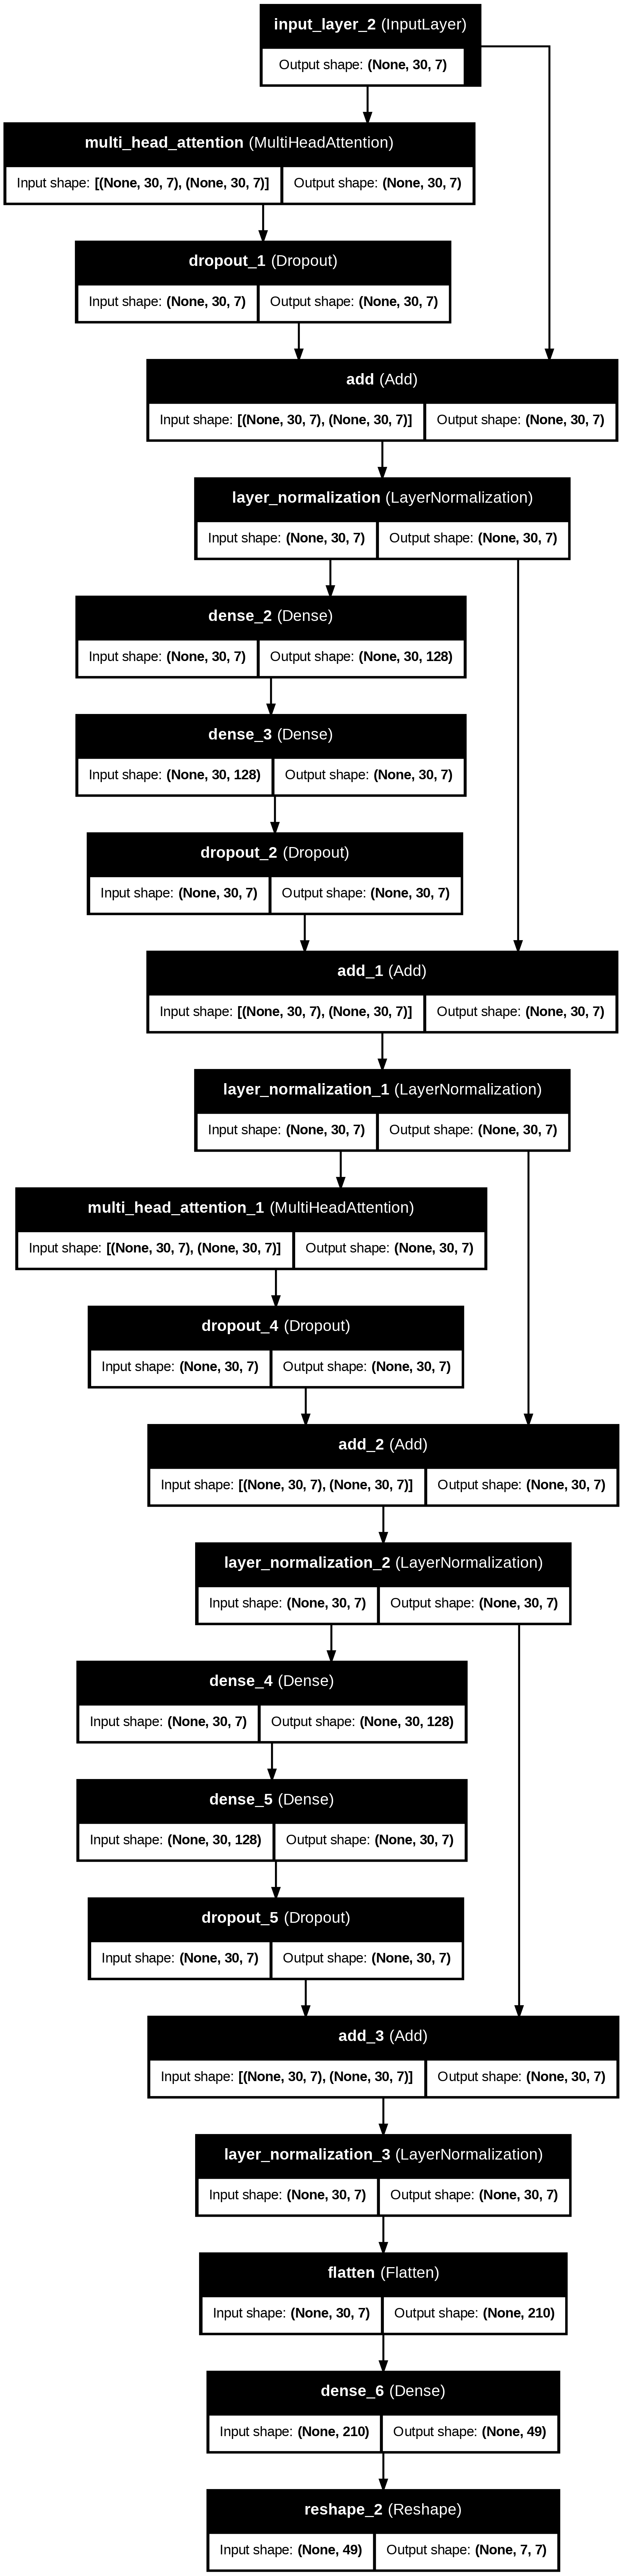

In [30]:
from tensorflow.keras.utils import plot_model

plot_model(model_tf, show_shapes=True, show_layer_names=True)